In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor, LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [3]:
# Load the dataset
dataset = pd.read_csv('/content/Train.csv')

In [29]:
print(dataset.head())

   Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type  \
0              156         9.30                 0         0.016047          4   
1                8         5.92                 1         0.019278         14   
2              662        17.50                 0         0.016760         10   
3             1121        19.20                 1         0.000000          6   
4             1297         8.93                 0         0.000000          9   

   Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  \
0  249.8092                  9                       1999            1   
1   48.2692                  3                       2009            1   
2  141.6180                  9                       1999            1   
3  182.0950                  0                       1998            2   
4   53.8614                  1                       1987            0   

   Outlet_Location_Type  Outlet_Type  Item_Outlet_Sales  
0         

In [31]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8480 entries, 0 to 8479
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8480 non-null   int64  
 1   Item_Weight                8480 non-null   float64
 2   Item_Fat_Content           8480 non-null   int64  
 3   Item_Visibility            8480 non-null   float64
 4   Item_Type                  8480 non-null   int64  
 5   Item_MRP                   8480 non-null   float64
 6   Outlet_Identifier          8480 non-null   int64  
 7   Outlet_Establishment_Year  8480 non-null   int64  
 8   Outlet_Size                8480 non-null   int64  
 9   Outlet_Location_Type       8480 non-null   int64  
 10  Outlet_Type                8480 non-null   int64  
 11  Item_Outlet_Sales          8480 non-null   float64
dtypes: float64(4), int64(8)
memory usage: 795.1 KB
None


In [32]:
print(dataset.describe())

       Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
count      8480.000000  8480.000000       8480.000000      8480.000000   
mean        780.407665    12.861323          0.353538         0.065846   
std         449.006842     4.216116          0.478096         0.051013   
min           0.000000     4.610000          0.000000         0.000000   
25%         396.750000     9.310000          0.000000         0.026940   
50%         784.000000    12.857645          0.000000         0.053799   
75%        1168.000000    16.000000          1.000000         0.094467   
max        1558.000000    21.250000          1.000000         0.304737   

         Item_Type     Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  \
count  8480.000000  8480.000000        8480.000000                8480.000000   
mean      7.227594   140.952122           4.725472                1997.846816   
std       4.208292    62.084969           2.836274                   8.369419   
min      

In [30]:
# Check for missing values
missing_values = dataset.isnull().sum()
print(missing_values)

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64


In [5]:
# Data Imputation
dataset['Item_Weight'].fillna(dataset['Item_Weight'].mean(), inplace=True)
mode_of_Outlet_size = dataset.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))
missing_size = dataset['Outlet_Size'].isnull()
dataset.loc[missing_size, 'Outlet_Size'] = dataset.loc[missing_size, 'Outlet_Type'].apply(lambda x: mode_of_Outlet_size[x])


In [6]:
# Data Preprocessing
dataset.replace({'Item_Fat_Content': {'low fat': 'Low Fat', 'LF': 'Low Fat', 'reg': 'Regular'}}, inplace=True)
encoder = LabelEncoder()
categorical_features = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [7]:
for feature in categorical_features:
    dataset[feature] = encoder.fit_transform(dataset[feature])


In [8]:
# Outlier removal
for feature in ['Item_Weight', 'Item_Visibility', 'Item_MRP']:
    min_val, max_val = dataset[feature].quantile([0.001, 0.999])
    dataset = dataset[(dataset[feature] >= min_val) & (dataset[feature] <= max_val)]


In [9]:
# Reset the index
dataset.reset_index(drop=True, inplace=True)


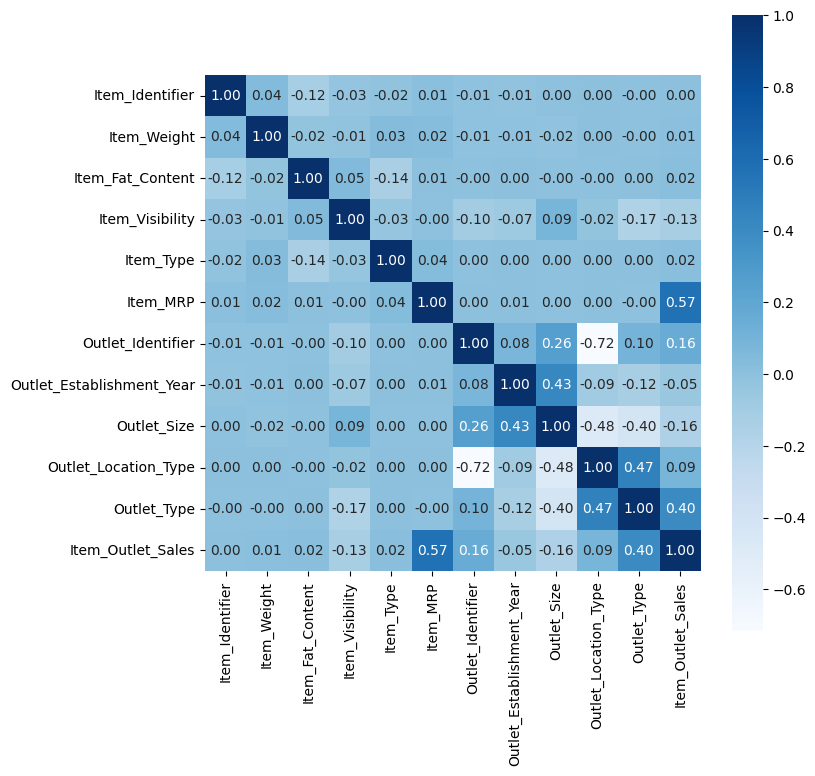

In [12]:
# Data Exploration
corr = dataset.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, cbar=True, cmap='Blues', square=True, annot=True, fmt='.2f')
plt.show()

In [13]:
# Feature Scaling and Dimensionality Reduction
X = dataset.drop('Item_Outlet_Sales', axis=1)
y = dataset['Item_Outlet_Sales']
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_norm)

<ipython-input-23-18a0cda8d042>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, bins=30)


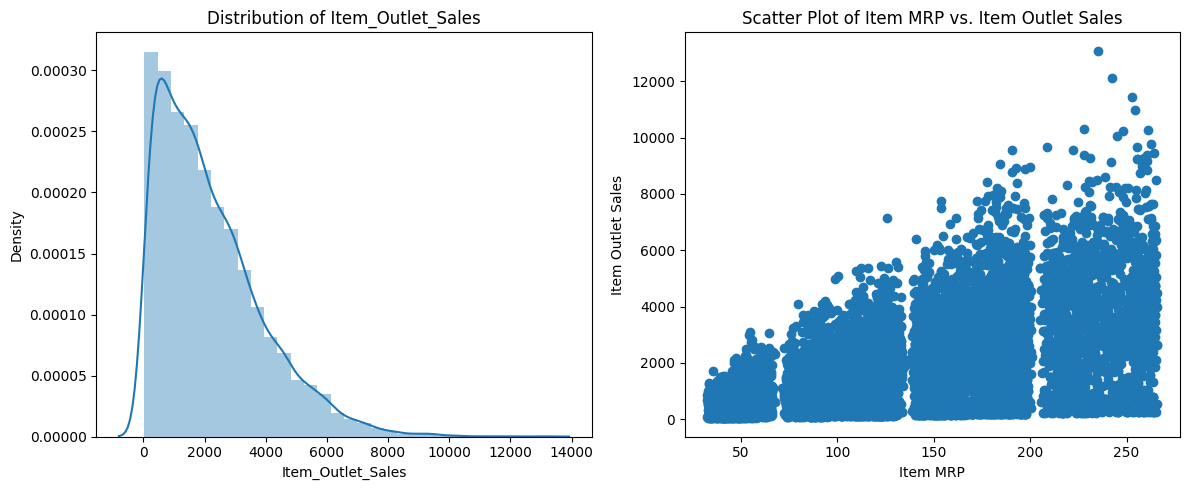

In [23]:
# Additional Analysis Charts
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.distplot(y, bins=30)
plt.title('Distribution of Item_Outlet_Sales')

plt.subplot(1, 2, 2)
plt.scatter(dataset['Item_MRP'], y)
plt.xlabel('Item MRP')
plt.ylabel('Item Outlet Sales')
plt.title('Scatter Plot of Item MRP vs. Item Outlet Sales')

plt.tight_layout()
plt.show()

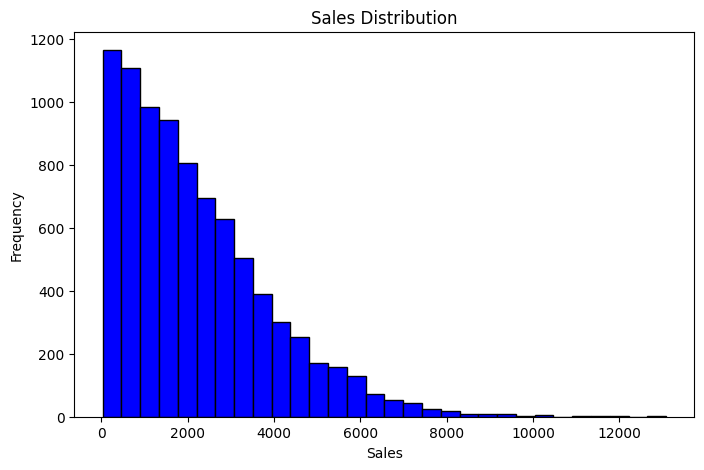

In [27]:
# Sales Distribution Histogram
plt.figure(figsize=(8, 5))
plt.hist(y, bins=30, color='blue', edgecolor='black')
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)


In [15]:
#Model Training
sgdr = SGDRegressor(max_iter=1000)
sgdr.fit(X_train, y_train)

SGDRegressor()

In [16]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [17]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)


LinearRegression()

In [18]:
# Make predictions
y_pred_sgd = sgdr.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_lr = lr.predict(X_test)

In [19]:
# Evaluation
mae_sgd = mean_absolute_error(y_test, y_pred_sgd)
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

In [20]:
# Linear Regression Metrics
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

In [21]:
# Print evaluation metrics
print("SGD Regressor Metrics:")
print("Mean Absolute Error:", mae_sgd)
print("Mean Squared Error:", mse_sgd)
print("R-squared:", r2_sgd)

print("\nXGBoost Regressor Metrics:")
print("Mean Absolute Error:", mae_xgb)
print("Mean Squared Error:", mse_xgb)
print("R-squared:", r2_xgb)

# Linear Regression Metrics
print("\nLinear Regression Metrics:")
print("Mean Absolute Error:", mae_lr)
print("Mean Squared Error:", mse_lr)
print("R-squared:", r2_lr)

SGD Regressor Metrics:
Mean Absolute Error: 863.5445282352505
Mean Squared Error: 1332123.7638273847
R-squared: 0.5143858993628395

XGBoost Regressor Metrics:
Mean Absolute Error: 825.5770810381656
Mean Squared Error: 1362300.0509504557
R-squared: 0.5033853970598585

Linear Regression Metrics:
Mean Absolute Error: 856.9321622641554
Mean Squared Error: 1325887.7300555017
R-squared: 0.5166591910898597
